### Starting Analysis from Validated Data
---
From this point, we can explore various analytical paths, such as dimensionality reduction, clustering, differential expression analysis, or graph-based modeling, depending on the research objectives. By working with a well-structured and schema-compliant dataset, we streamline the analysis process and improve the reliability of our insights

In [ ]:
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import anndata
import scipy.sparse as sp
from tqdm import tqdm
import torch
from captum.attr import IntegratedGradients
import copy

In [2]:
import lamindb as ln
import bionty as bt

→ connected lamindb: laminlabs/lamindata


In [ ]:
ln.Project.df()

In [ ]:
ln.track(project="9M7iVOgQ8VAQ")

Anyone looking to start the analysis from (filtered) data can search the artifacts registry and retrieve the .h5ad file containing the filtered matrix.

In [6]:
#search
ln.Artifact.features.filter(experiment__icontains="Breast Cancer").df()

OperationalError: connection to server at "database2.cmyfs24wugc3.us-east-1.rds.amazonaws.com" (3.211.54.97), port 5432 failed: Operation timed out
	Is the server running on that host and accepting TCP/IP connections?


In [7]:
adata_artifact = ln.Artifact.get("Jwd7e43QzRxZ7OSj0000")

In [ ]:
adata_artifact.describe()

In [9]:
adata = adata_artifact.load()

### Starting the ML Workflow & Saving Model Artifacts

Our example workflow follows these key steps:

- Extract latent representations from scRNA-seq data using scVI. [This can be compute intensive and we save these in our data]
- Construct a bipartite cell-gene graph, capturing relationships between cells and genes.
- Train a Heterogeneous Graph Neural Network (GNN) for cell classification, leveraging structured graph information.
- Interpret model predictions using Integrated Gradients (IG) to gain insights into feature importance.

These steps are already defined in a function called `run_analysis`.

By saving trained models and artifacts with metadata, we ensure that future analyses can easily reuse, validate, or extend the workflow without retraining from scratch.

#### Model Hyper parameters which we are going to use
---

In [ ]:
ln.Param(name="epochs", dtype=int).save()
ln.Param(name="learning_rate", dtype=float).save()

In [ ]:
from run_analysis import run_analysis
import scanpy as sc

In [ ]:
@ln.tracked()
def run_analysis_w_params(
    adata: sc.AnnData,
    epochs: int,
    learning_rate: float,
) -> None:
    GNN_model, graph_data, scvi_model = run_analysis(adata=adata, epochs=epochs, learning_rate=learning_rate)

    # define model path
    gnn_model_path = f"./data/GSE180286/GSE180286_gnn_model_ep{epochs}_lr{learning_rate}.pth"

    # save model state
    torch.save(GNN_model.state_dict(), gnn_model_path)

    # save model artifact
    gnn_model_artifact = ln.Artifact(
        gnn_model_path,
        description=f"Single Cell RNA-seq GNN Model trained [GSE180286], "
                    f"preprocessed and filtered data. Epochs: {epochs}, "
                    f"Learning Rate: {learning_rate}",
        kind="model"
    ).save()

    gnn_model_artifact.params.add_values({
        "epochs": epochs,
        "learning_rate":learning_rate
        }
    )
    return gnn_model_artifact, graph_data, GNN_model, scvi_model

In [15]:
gnn_model_artifact, graph_data, GNN_model, model = run_analysis_w_params(adata=adata, epochs=50, learning_rate=0.002)

! cannot infer feature type of: AnnData object with n_obs × n_vars = 42049 × 2000
    obs: 'patient', 'site', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts', returning '?


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [00:57<00:00, 11.60s/it, v_num=1, train_loss_step=283, train_loss_epoch=292]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [00:57<00:00, 11.60s/it, v_num=1, train_loss_step=283, train_loss_epoch=292]
Epoch 0, Loss: 0.7365, Accuracy: 0.5117
Epoch 10, Loss: 0.3042, Accuracy: 0.8816
Epoch 20, Loss: 0.2540, Accuracy: 0.8946
Epoch 30, Loss: 0.2285, Accuracy: 0.9074
Epoch 40, Loss: 0.2134, Accuracy: 0.9136


In [ ]:
gnn_model_artifact.describe()

#### Interpret Model Using Integrated Gradients
---
Integrated gradients is an attribution method that will help us dissect what cell features are most important for the classification of the GNN. To read more about integrated gradients, visit [this page](https://towardsdatascience.com/interpreting-deep-neural-networks-using-integrated-gradients-f9b8ecdd3c57/). 

In [ ]:
def interpret_cell(cell_idx, graph_data, GNN_model):
    """Computes integrated gradients for a given cell in the GNN model."""

    def model_forward_for_cell(cell_features):
        """Custom forward function for computing gradients."""
        outputs = []
        # loop over each interpolated input
        for i in range(cell_features.shape[0]):
            data_modified = copy.deepcopy(graph_data)
            # verify feature for target cell is 1D
            feat = cell_features[i].squeeze()
            data_modified['cell'].x[cell_idx] = feat  
            out, _ = GNN_model(data_modified)
            # out shape [n_cells, 2]
            target_logit = out[cell_idx, 1]  
            outputs.append(target_logit.unsqueeze(0))
        return torch.cat(outputs, dim=0)  # shape: (n_steps,)

    ig = IntegratedGradients(model_forward_for_cell)

    # get original features e
    original_features = graph_data['cell'].x[cell_idx].unsqueeze(0)  # shape: (1, feature_dim)
    baseline = torch.zeros_like(original_features)  # verify baseline has same shape as original_features

    # compute attributions
    attributions, _ = ig.attribute(
        inputs=original_features,
        baselines=baseline,
        n_steps=50,
        internal_batch_size=1,
        return_convergence_delta=True
    )

    return attributions, original_features

### Interpret a sample cell
Note in practice we would do this for all cells and compute summary statistics.

In [ ]:
cell_idx = 0
attr , original_cell_features= interpret_cell(cell_idx, graph_data, GNN_model)
print(f"Attributions for Cell {cell_idx}:", attr)

Attributions for Cell 0: tensor([[-0.0441, -0.0869, -0.3890, -0.0392, -0.0513,  0.3811,  0.1032,  0.0497,
         -0.4494,  0.1793]], dtype=torch.float64)


#### Finally, we compute gene gradients with respect to latent representation

In [ ]:
counts_cell0 = adata.layers["counts"][cell_idx].toarray()
library_size_cell0 = torch.tensor(counts_cell0.sum(), dtype=torch.float32).unsqueeze(0)

# --- gradients for each gene ---
original_cell_features_with_grad = original_cell_features.detach().clone()
original_cell_features_with_grad.requires_grad_(True)

# get number of genes and latent dimensions
n_genes = adata.shape[1]  
latent_dim = original_cell_features_with_grad.shape[1] 

# batch info tensor
batch_cats = torch.zeros(1, model.module.n_batch)
batch_cats[0, 0] = 1.0  # Use first batch

# library size
if isinstance(library_size_cell0, torch.Tensor):
    library = library_size_cell0
else:
    library = torch.ones(1, 1) 

# generate expression 
pred_expr = model.module.decoder(
    "gene",  # dispersion mode
    original_cell_features_with_grad,  # grad tracking
    library,  
    batch_cats 
)

expression = pred_expr[0]  # shape: [1, n_genes]
print("Expression shape:", expression.shape)

In [ ]:
# collect gradients for each gene
grad_matrix = []
for gene_idx in range(n_genes):
    # check if gene has non-zero expression 
    if expression[0, gene_idx] > 1e-10:
        # gradient of gene's expression with respect to latent vector
        grad_gene = torch.autograd.grad(
            outputs=expression[0, gene_idx],
            inputs=original_cell_features_with_grad,
            retain_graph=True,  # retain graph for backward passes
            create_graph=False  # higher-order gradients not needed
        )[0]
        
        # store gradient for this gene
        grad_matrix.append(grad_gene.detach().cpu())
    else:
        # use zeros as gradient for genes with zero expression
        grad_matrix.append(torch.zeros_like(original_cell_features_with_grad[0]).cpu())

# convert list of gradients to tensor
grad_matrix = torch.stack(grad_matrix)
print("Gradient matrix shape:", grad_matrix.shape)  # [n_genes, latent_dim]

# remove extra dimension
grad_matrix = grad_matrix.squeeze(1)  
print("Reshaped gradient matrix:", grad_matrix.shape)

# calculate magnitude of gradient for each gene (across all latent dimensions)
grad_magnitude = torch.norm(grad_matrix, dim=1)
print("Gradient magnitude shape:", grad_magnitude.shape)

### Visualizations

Expression shape: torch.Size([1, 2000])
Gradient matrix shape: torch.Size([2000, 1, 10])
Reshaped gradient matrix: torch.Size([2000, 10])
Gradient magnitude shape: torch.Size([2000])
Top 10 genes with highest gradient magnitude:
1. IGLC2: 0.1805
2. IGKC: 0.1118
3. IGHG4: 0.0918
4. MALAT1: 0.0644
5. IGLC3: 0.0521
6. IGHG1: 0.0343
7. MT-RNR2: 0.0266
8. IGHG3: 0.0175
9. IGHM: 0.0114
10. NKAPP1: 0.0110


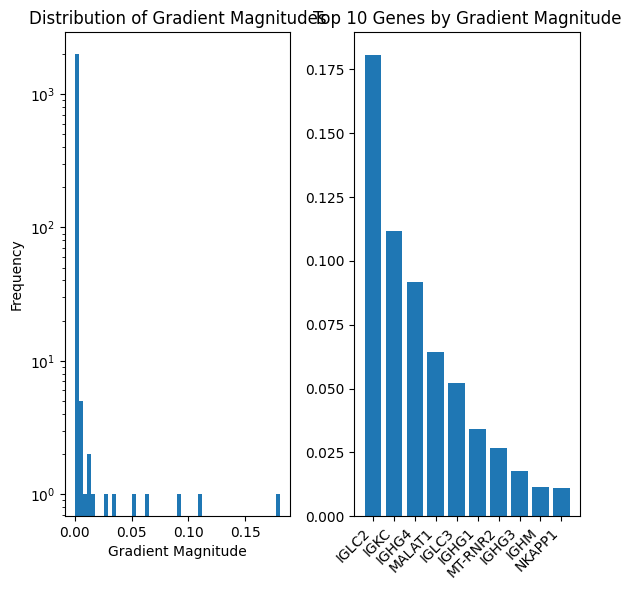

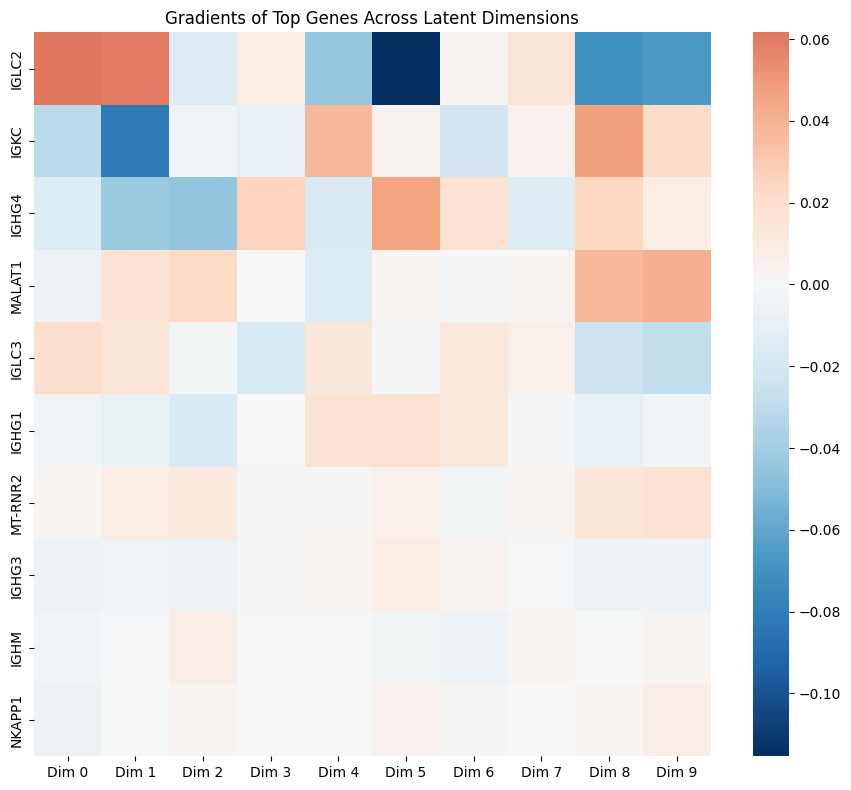


Latent dimension 0 most influences genes:
  1. IGLC2: 0.0616
  2. IGKC: 0.0315
  3. IGLC3: 0.0201
  4. IGHG4: 0.0165
  5. IGHG3: 0.0075

Latent dimension 1 most influences genes:
  1. IGKC: 0.0825
  2. IGLC2: 0.0600
  3. IGHG4: 0.0428
  4. MALAT1: 0.0154
  5. IGLC3: 0.0146

Latent dimension 2 most influences genes:
  1. IGHG4: 0.0462
  2. MALAT1: 0.0228
  3. IGHG1: 0.0168
  4. IGLC2: 0.0149
  5. MT-RNR2: 0.0113

Latent dimension 3 most influences genes:
  1. IGHG4: 0.0264
  2. IGLC3: 0.0186
  3. IGKC: 0.0098
  4. IGLC2: 0.0090
  5. MT-RNR2: 0.0026

Latent dimension 4 most influences genes:
  1. IGLC2: 0.0442
  2. IGKC: 0.0372
  3. IGHG4: 0.0170
  4. IGHG1: 0.0162
  5. MALAT1: 0.0158

Latent dimension 5 most influences genes:
  1. IGLC2: 0.1154
  2. IGHG4: 0.0451
  3. IGHG1: 0.0177
  4. IGHG3: 0.0088
  5. MT-RNR2: 0.0058

Latent dimension 6 most influences genes:
  1. IGKC: 0.0211
  2. IGHG4: 0.0172
  3. IGLC3: 0.0117
  4. IGHG1: 0.0113
  5. IGHM: 0.0065

Latent dimension 7 most influe

In [ ]:
# top 10 genes with highest gradient magnitude
top10_indices = torch.argsort(grad_magnitude, descending=True)[:10]
top10_genes = [adata.var_names[int(i)] for i in top10_indices]
print("Top 10 genes with highest gradient magnitude:")
for i, gene in enumerate(top10_genes):
    print(f"{i+1}. {gene}: {grad_magnitude[top10_indices[i]].item():.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))

# distribution of gradient magnitudes
plt.subplot(1, 2, 1)
plt.hist(grad_magnitude.numpy(), bins=50)
plt.title("Distribution of Gradient Magnitudes")
plt.xlabel("Gradient Magnitude")
plt.ylabel("Frequency")
plt.yscale('log')  # Log scale for better visibility

# top genes by magnitude
plt.subplot(1, 2, 2)
top10_values = grad_magnitude[top10_indices].numpy()
plt.bar(range(10), top10_values)
plt.xticks(range(10), top10_genes, rotation=45, ha='right')
plt.title("Top 10 Genes by Gradient Magnitude")
plt.tight_layout()
plt.show()

# heatmap of gradients for top genes across latent dimensions
plt.figure(figsize=(9, 8))
top_gene_gradients = grad_matrix[top10_indices].numpy()
sns.heatmap(top_gene_gradients, cmap="RdBu_r", center=0,
            xticklabels=[f"Dim {i}" for i in range(latent_dim)],
            yticklabels=top10_genes)
plt.title("Gradients of Top Genes Across Latent Dimensions")
plt.tight_layout()
plt.show()

# find which genes are most influenced per latent dimension
for dim in range(latent_dim):
    dim_influence = abs(grad_matrix[:, dim])
    top5_idx = torch.argsort(dim_influence, descending=True)[:5]
    top5_genes = [adata.var_names[int(i)] for i in top5_idx]
    print(f"\nLatent dimension {dim} most influences genes:")
    for i, gene in enumerate(top5_genes):
        print(f"  {i+1}. {gene}: {dim_influence[top5_idx[i]].item():.4f}")

## Key Findings:
---
Based on the analysis of matched primary breast cancer tumors and lymph node metastases, we can identify crucial transcriptional changes that facilitate tumor spread to lymphoid tissue. The most influential genes across latent dimensions highlight key biological processes involved in immune evasion, adaptation to the lymphatic microenvironment, and metabolic rewiring.

1. **Immune Evasion & Tumor-Immune Interactions**
The dominance of IGLC2, IGKC, and IGHG4 in multiple latent dimensions implicates a major role for B-cell and plasma cell-related processes in LN metastasis. The enrichment of these genes points to:

- Plasma cell infiltration & humoral immunity: The LN is a key immune organ where B cells mature and secrete antibodies. Overexpression of immunoglobulin light and heavy chains could indicate the presence of tumor-associated plasma cells.

- Tumor-driven immune modulation: Cancer cells may induce B-cell dysfunction or exhaustion, where B cells contribute to an immunosuppressive tumor microenvironment instead of mounting an anti-tumor response.

- Potential antibody-secreting tumor phenotype: Some breast cancer cells can aberrantly express immunoglobulin genes, helping with immune evasion and survival in the lymphatic niche.

2. **Metabolic Adaptation & Stress Response**
The mitochondrial gene MT-RNR2 (encoding a key ribosomal RNA) emerges as a recurrent player in metastatic LN samples. Its implications include:

- Mitochondrial adaptation to lymphatic metastasis: Cancer cells in the LN may undergo metabolic rewiring, favoring mitochondrial translation and oxidative phosphorylation to survive in a nutrient-limited, immune-surveilled microenvironment.

- Anti-apoptotic properties: MT-RNR2 encodes a fragment known as Humanin, a peptide with cytoprotective effects, which can help metastatic cancer cells resist apoptosis and survive oxidative stress.

- Increased resistance to immune-mediated cell death: Mitochondrial adaptations like MT-RNR2 upregulation might protect metastatic cells from T-cell or NK-cell-mediated killing.


### Potential Next Steps:
- Perform cell-type deconvolution to determine whether immunoglobulin expression is tumor-intrinsic or derived from infiltrating B-cells
- Check whether MALAT1 upregulation correlates with specific signaling pathways (e.g., EMT, Notch, Wnt) in LN metastases
- Explore whether targeting mitochondrial function can reduce metastatic potential
- Move to notebook 4 in this guide to see how you can integrate additional breast cancer datasets to your analysis 